# I. Import libraries and dataset 

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)
import ta
import sys
import os
sys.path.append(os.path.abspath("../src"))

In [2]:
VIC = pd.read_csv('../Datasets/VIC.csv')

# II. EDA 

## 1. Statistic

In [3]:
VIC.head(170)

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,VIC,10/17/2018 9:39,98.5,98.5,98.5,98.5,390,0
1,VIC,10/17/2018 9:40,98.5,98.5,98.5,98.5,760,0
2,VIC,10/17/2018 9:41,98.6,98.6,98.6,98.6,2060,0
3,VIC,10/17/2018 9:42,98.6,98.6,98.6,98.6,5540,0
4,VIC,10/17/2018 9:43,98.6,98.7,98.6,98.7,760,0
...,...,...,...,...,...,...,...,...
165,VIC,10/17/2018 14:28,98.4,98.5,98.4,98.5,1880,0
166,VIC,10/17/2018 14:29,98.5,98.5,98.5,98.5,1500,0
167,VIC,10/17/2018 14:46,99.0,99.0,99.0,99.0,203400,0
168,VIC,10/18/2018 9:15,98.5,98.5,98.5,98.5,12900,0


In [4]:
VIC.describe()

,Open,High,Low,Close,Volume,Open Interest
count,101266.000000,101266.000000,101266.000000,101266.000000,1.012660e+05,101266.0
mean,105.376460,105.418519,105.334147,105.378791,3.182640e+03,0.0
std,11.543158,11.535584,11.552338,11.545054,1.469814e+04,0.0
min,68.000000,68.000000,68.000000,68.000000,1.000000e+01,0.0
25%,95.400000,95.400000,95.300000,95.400000,2.300000e+02,0.0
50%,105.300000,105.300000,105.200000,105.300000,1.020000e+03,0.0
75%,115.800000,115.900000,115.800000,115.800000,3.000000e+03,0.0
max,126.100000,126.500000,126.100000,126.500000,1.468390e+06,0.0


- Dataset VIC gồm có 101266 samples, là các dữ liệu về giá OHLC, volumne, open interest của mã cổ phiếu VIC, được ghi nhận từ ngày 17/10/2018 đến 22/12/2020.
- Các giá trị đều nằm trong khoảng hợp lệ (không có giá trị nào âm).

In [5]:
VIC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101266 entries, 0 to 101265
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         101266 non-null  object 
 1   Date/Time      101266 non-null  object 
 2   Open           101266 non-null  float64
 3   High           101266 non-null  float64
 4   Low            101266 non-null  float64
 5   Close          101266 non-null  float64
 6   Volume         101266 non-null  int64  
 7   Open Interest  101266 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 6.2+ MB


In [6]:
VIC.duplicated().sum()

0

- Dataset khá clean khi không có missing và duplicated value.
- Tuy nhiên các mốc thời gian ghi nhận trong dataset lại rời rạc và chỉ ghi nhận một vài thời điểm trong ngày.

## 2. Close price visualization

- Dataset sẽ được gộp lại, thành ghi nhận theo ngày.

In [7]:
from preprocessing import aggregate_intraday_to_daily

In [8]:
VIC = aggregate_intraday_to_daily(VIC)

In [9]:
VIC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    548 non-null    object 
 1   Open    548 non-null    float64
 2   High    548 non-null    float64
 3   Low     548 non-null    float64
 4   Close   548 non-null    float64
 5   Volume  548 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 25.8+ KB


- Sau khi gộp lại theo ngày, số samples giảm xuống còn lại 548 samples, khớp với tổng số ngày thị trường chứng khoán hoạt động từ 25/12/2018 đến 22/12/2020.

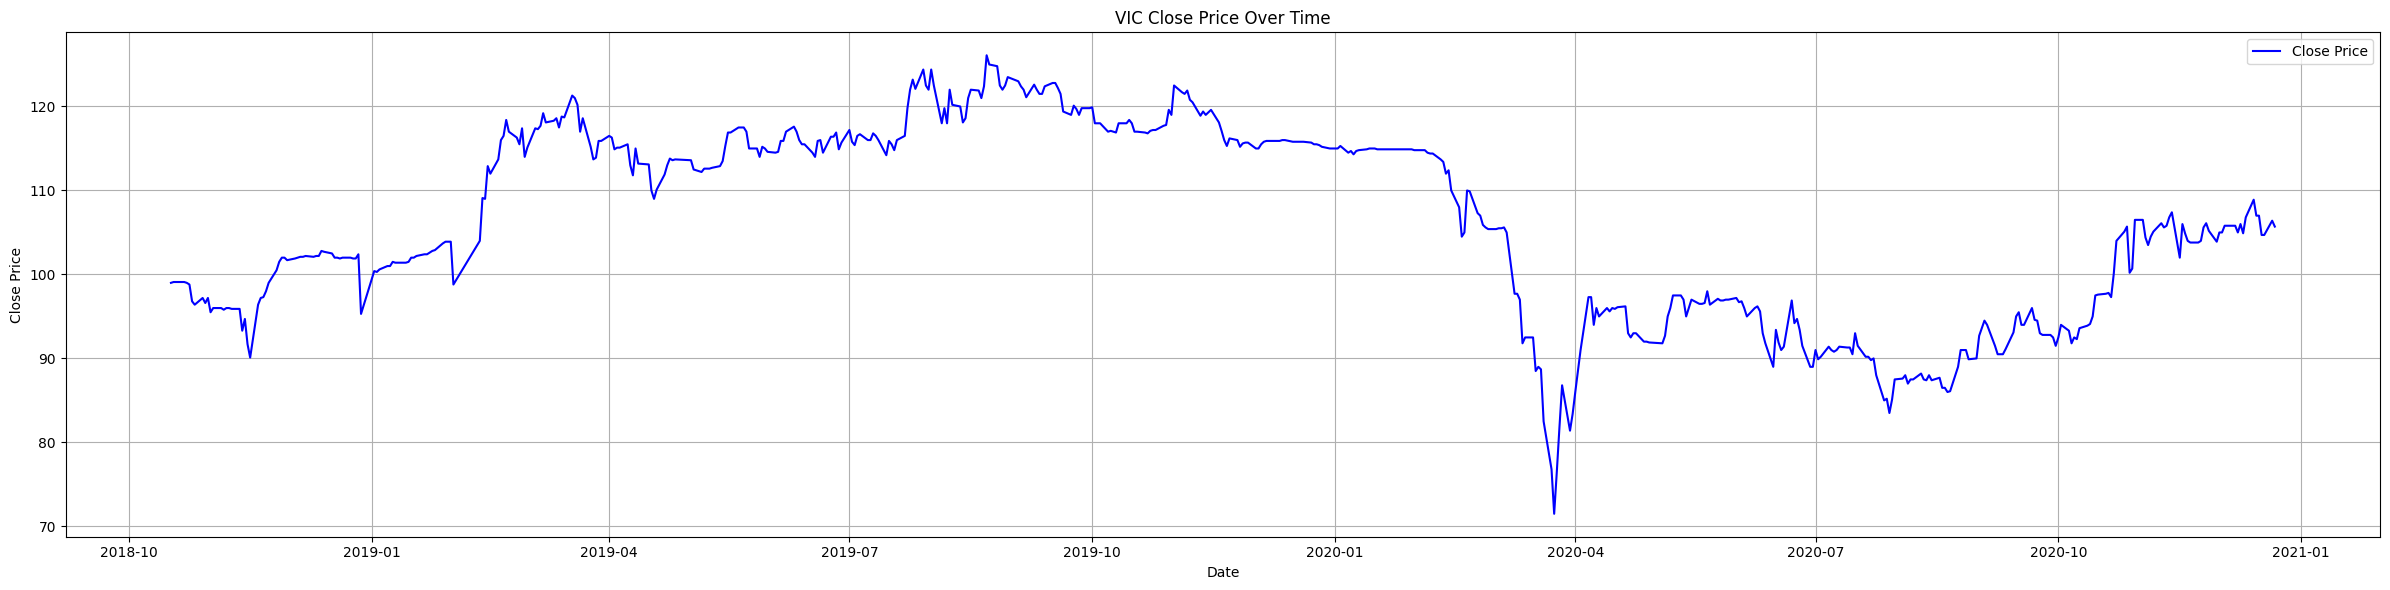

In [10]:
plt.figure(figsize=(24, 6))
plt.plot(VIC['Date'], VIC['Close'], label='Close Price', color='blue')
plt.title('VIC Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Từ 10/2018 đến 12/2019, giá VIC tăng mạnh từ 90.000/cổ phiếu lên 120.000/cổ phiếu.
- Từ 1/2020 đến 3/2020, giá giảm rất mạnh từ 110.000/cổ phiếu xuống dưới 75.000/cổ phiếu, cùng thời điểm bùng phát dịch COVID-19.
- Giai đoạn sau đó, giá phục hồi dần và tăng trở lại lên gần 110.000/cổ phiếu.

## 3. Volume over time

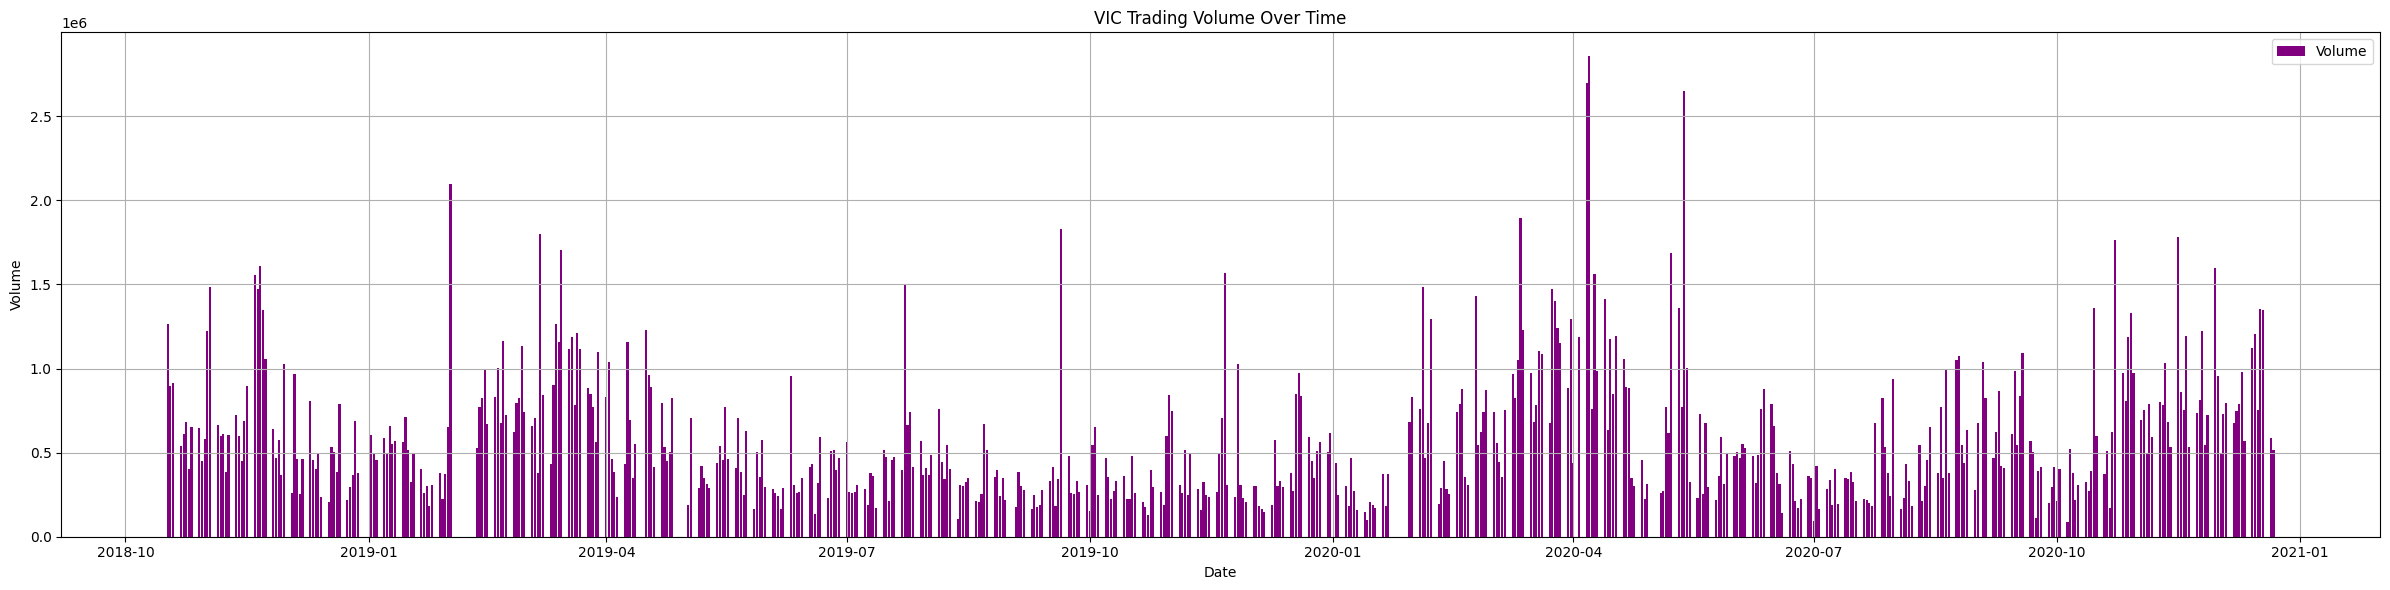

In [11]:
plt.figure(figsize=(24, 6))
plt.bar(VIC['Date'], VIC['Volume'], color='purple', label='Volume')
plt.title('VIC Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Volume có sự biến động mạnh và chênh lệch lớn giữa các ngày, do việc gộp dữ liệu ở trên.

## 4. Rate of return

In [12]:
from preprocessing import return_volatility_target

In [13]:
VIC = return_volatility_target(VIC)

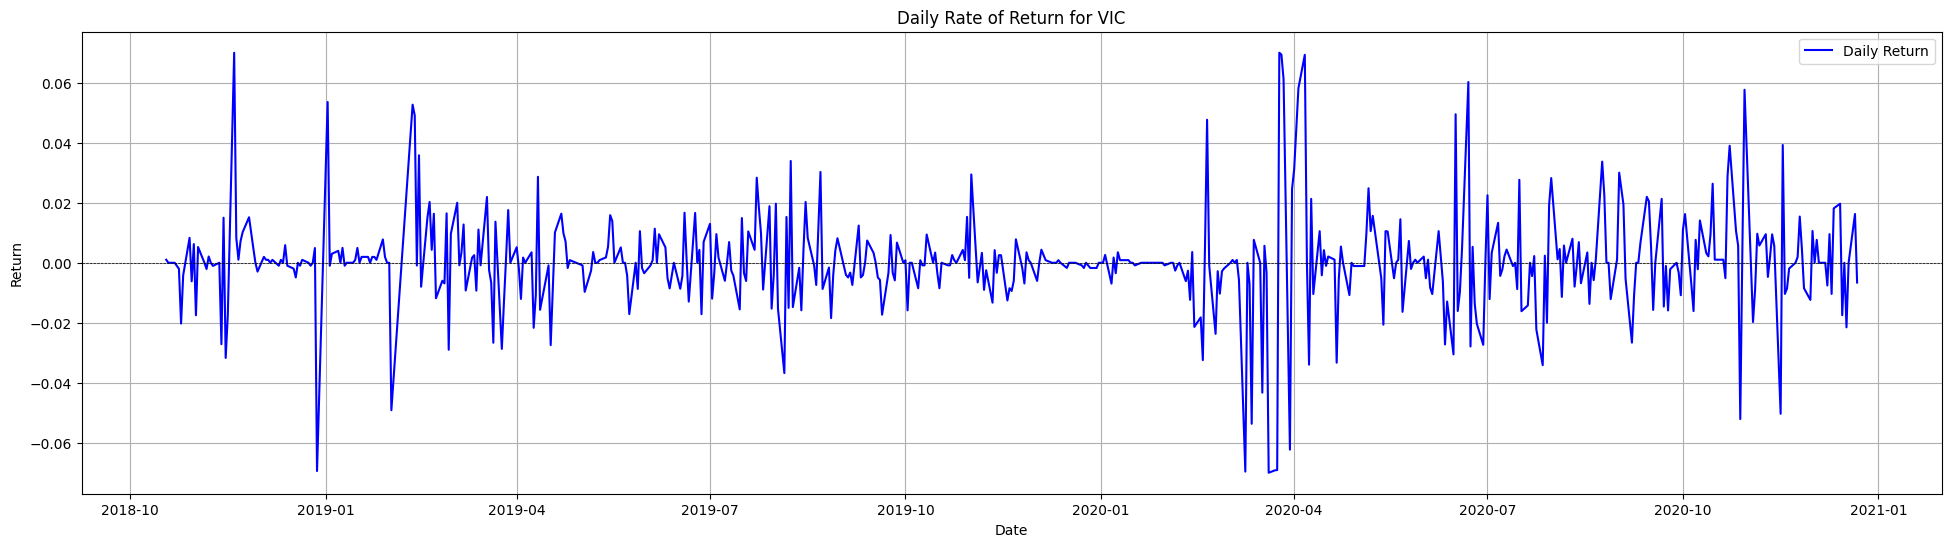

In [14]:
plt.figure(figsize=(24, 6))
plt.plot(VIC['Date'], VIC['Return'], label='Daily Return', color='blue')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.title('Daily Rate of Return for VIC')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.show()

- Lợi suất hàng ngày của cổ phiếu VIC dao động quanh mức 0, với nhiều điểm biến động cao (tăng/giảm 6%), đặc biệt trong thời điểm COVID-19 bùng phát.

## 5. Volatility 

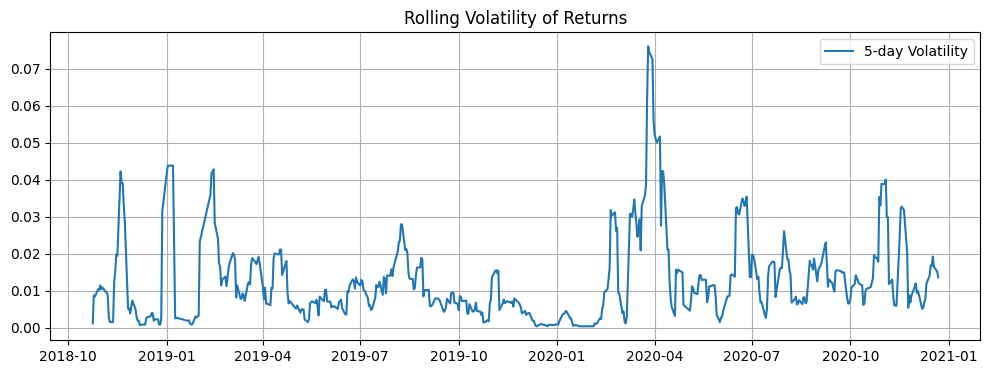

In [15]:
plt.figure(figsize=(12, 4))
plt.plot(VIC['Date'], VIC['volatility_5'], label='5-day Volatility')
plt.title('Rolling Volatility of Returns')
plt.grid(True)
plt.legend()
plt.show()

- Rolling volatility biến động mạnh ở cuối 2018 và giai đoạn đầu 2019, và đạt đỉnh 7.5% ở giai đoạn đầu 2020. 
- Sau đợt khủng hoảng, vẫn có nhiều điểm cao trong nửa cuối năm 2020, cho thấy sự bất ổn vẫn còn kéo dài.

# III. Preprocessing data 

## 1. Removing Outliers 

In [16]:
from preprocessing import remove_outliers_and_plot

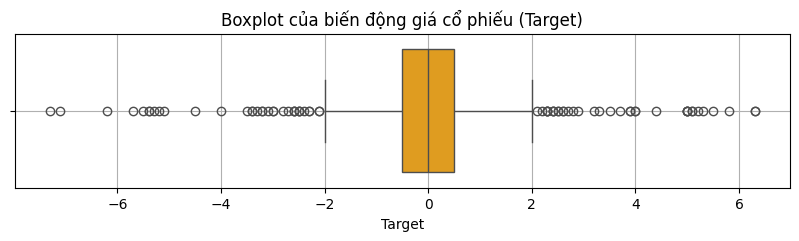

Số dòng còn lại sau khi loại outliers: 476


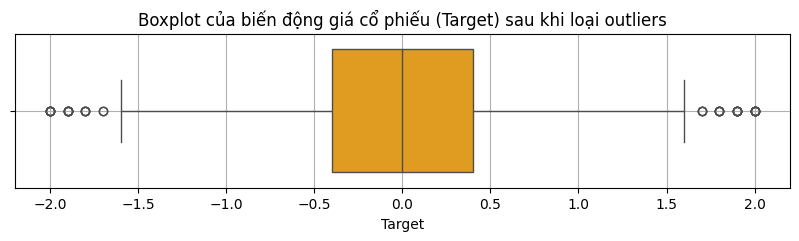

In [17]:
VIC = remove_outliers_and_plot(VIC)

- Thể hiện trên biểu đồ boxplot cho thấy có các giá trị outliers.
- Sau khi loại bỏ outliers, số lượng sample còn lại là 476.

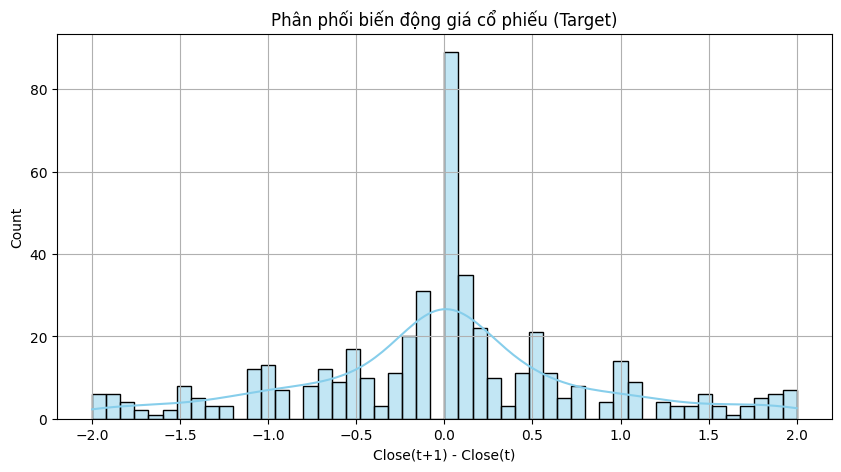

In [18]:
plt.figure(figsize=(10, 5))
sns.histplot(VIC['Target'], kde=True, bins=50, color='skyblue')
plt.title('Phân phối biến động giá cổ phiếu (Target)')
plt.xlabel('Close(t+1) - Close(t)')
plt.grid(True)
plt.show()

Sau khi xử lý loại bỏ outliers
- Distribution có hình dạng gần giống Normal Distribution.
- Center của distribution gần 0, nghĩa là phần lớn biến động hàng ngày của cổ phiếu là nhỏ.
- Tương đối là đối xứng, cho thấy khả năng tăng và giảm giá gần như là cân bằng.

## 2. Features engineering

- Thêm các features mới 

In [19]:
from preprocessing import feature_engineering

In [20]:
VIC = feature_engineering(VIC)

## 3. Data segregation

- Sau khi xử lý xong, data sẽ được chia thành các train, validate, test set để tiến hành train và evaluate model.

In [21]:
from data_segregation import split_time_series_data

In [22]:
features, target, X_trainval, X_test, y_trainval, y_test = split_time_series_data(VIC)

- Kiểm tra lại shape của dataset trước khi vào bước train model.

In [23]:
X_trainval.shape

(360, 33)

In [24]:
X_test.shape

(91, 33)

In [25]:
y_trainval.shape

(360,)

In [26]:
y_test.shape

(91,)

# IV. Model

## 1. Training

- Sử dụng model LightGBM để predict chênh lệch giá.

In [27]:
from data_segregation import time_series_cv

In [28]:
cv_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42, verbosity=-1)

val_scores, val_preds, val_trues, val_dates = time_series_cv(
    model=cv_model,
    X=X_trainval,
    y=y_trainval,
    dates=VIC, 
    n_splits=3
)

In [29]:
from visualization import plot_cv_predictions

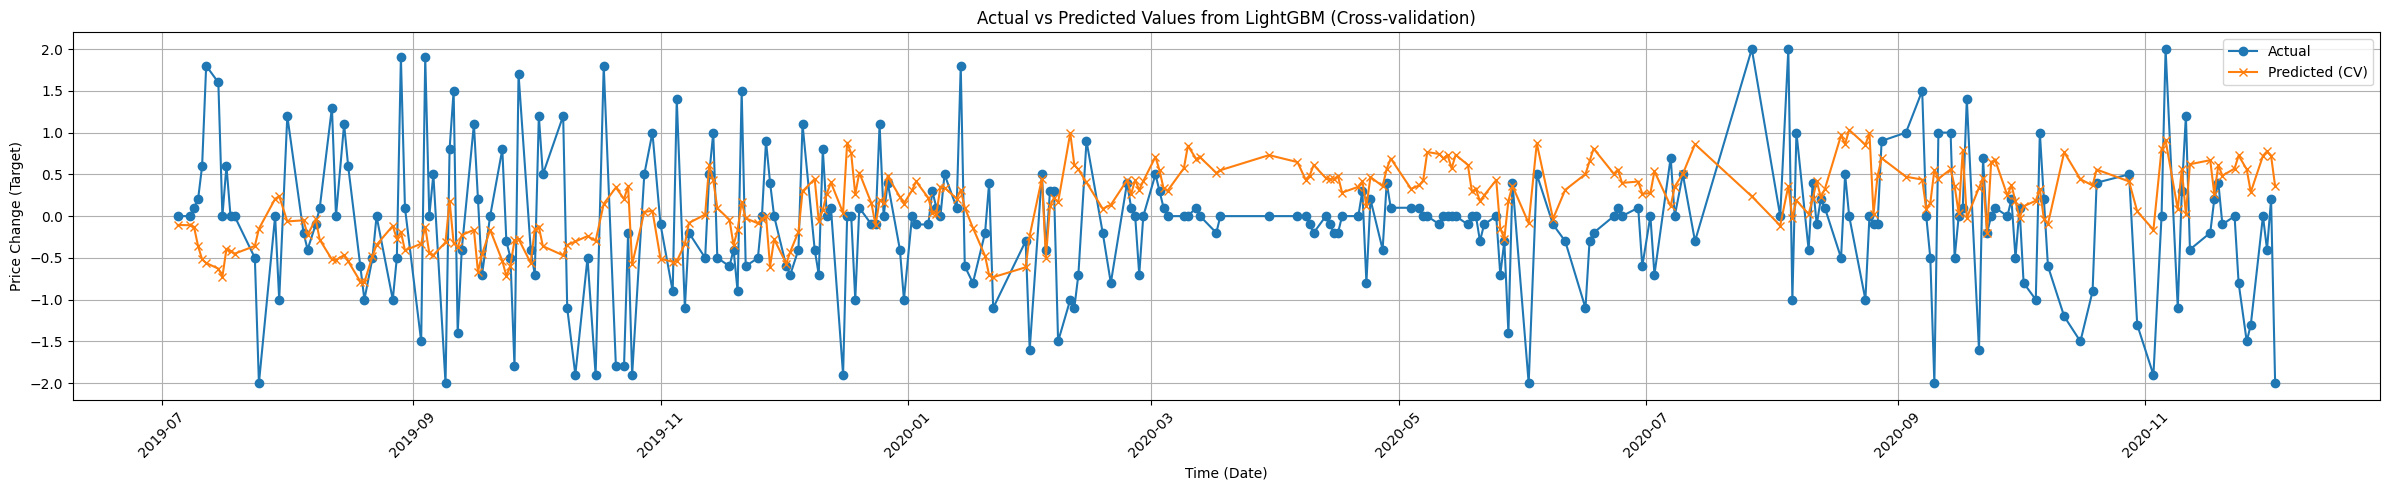

In [30]:
plot_cv_predictions(val_dates, val_trues, val_preds)

In [31]:
print(f"MAE trung bình (CV): {np.mean(val_scores):.4f}")

MAE trung bình (CV): 0.7269


- Model bắt được xu hướng nhưng biên độ nhỏ, có thời điểm không phản ứng đủ , nhưng cũng có thời điểm quá nhạy cảm với các biến động lên/xuống của giá.
- Có hiện tượng của underfitting. 
- MAE trên tập Cross-validation vào khoảng 0.7269 cho thấy mô hình có khác biệt lớn với biến động thực tế. 

## 2. Tunning 

- Sử dụng Optuna để tìm bộ hyper-parameters tối ưu.
- Kết quả tối ưu được đánh giá trên tập Cross-validation.

In [32]:
from tunning import optuna_objective

In [33]:
objective = optuna_objective(X_trainval, y_trainval, loss_type="rmse_corr", n_splits=3)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2025-05-10 16:11:31,898] A new study created in memory with name: no-name-ab57ce3a-032e-45a5-975a-d5eb51d0dc43
[I 2025-05-10 16:11:32,002] Trial 0 finished with value: 0.88629926370484 and parameters: {'n_estimators': 67, 'learning_rate': 0.14976631986645444, 'max_depth': 8, 'num_leaves': 25, 'min_child_samples': 19, 'subsample': 0.9407214420143347, 'colsample_bytree': 0.6541278913477638}. Best is trial 0 with value: 0.88629926370484.
[I 2025-05-10 16:11:32,094] Trial 1 finished with value: 0.9320167156926669 and parameters: {'n_estimators': 92, 'learning_rate': 0.124210300594576, 'max_depth': 8, 'num_leaves': 41, 'min_child_samples': 13, 'subsample': 0.6475029516139618, 'colsample_bytree': 0.7930505824001979}. Best is trial 0 with value: 0.88629926370484.
[I 2025-05-10 16:11:32,281] Trial 2 finished with value: 0.9567461868937425 and parameters: {'n_estimators': 290, 'learning_rate': 0.06702590429894298, 'max_depth': 10, 'num_leaves': 70, 'min_child_samples': 17, 'subsample': 0.667

Best hyperparameters: {'n_estimators': 147, 'learning_rate': 0.011217989519110518, 'max_depth': 4, 'num_leaves': 54, 'min_child_samples': 30, 'subsample': 0.7881316968740616, 'colsample_bytree': 0.8344732220331775}


## 3. Retraining and fetures importance

- Model sẽ được train lại một lần nữa với toàn bộ tập train và bộ hyper-parameter tối ưu vừa tìm được. 

In [34]:
best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(X_trainval, y_trainval)

y_pred_test = best_model.predict(X_test)

In [35]:
importances = best_model.feature_importances_
feat_names = features.columns
feat_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)
print(feat_df.head(10))

          Feature  Importance
2             Low         100
24   Close_vs_MA5          96
4          Volume          71
23  Volatility_20          69
5          Return          63
7    volatility_5          56
26   Volume_avg_5          53
3           Close          48
27   Volume_spike          45
29  Open_to_Close          33


- Các features được thêm vào có vai trò khá quan trọng, khi model dựa nhiều vào các features này để đưa ra quyết định.
- Các features có đóng góp nhiều nhất gồm: Low, Close_vs_MA5, Volume, Volatility_20, Return, volatility_5, Volume_avg_5, Close, Volume_spike, Open_to_Close.

In [36]:
from visualization import plot_test_predictions

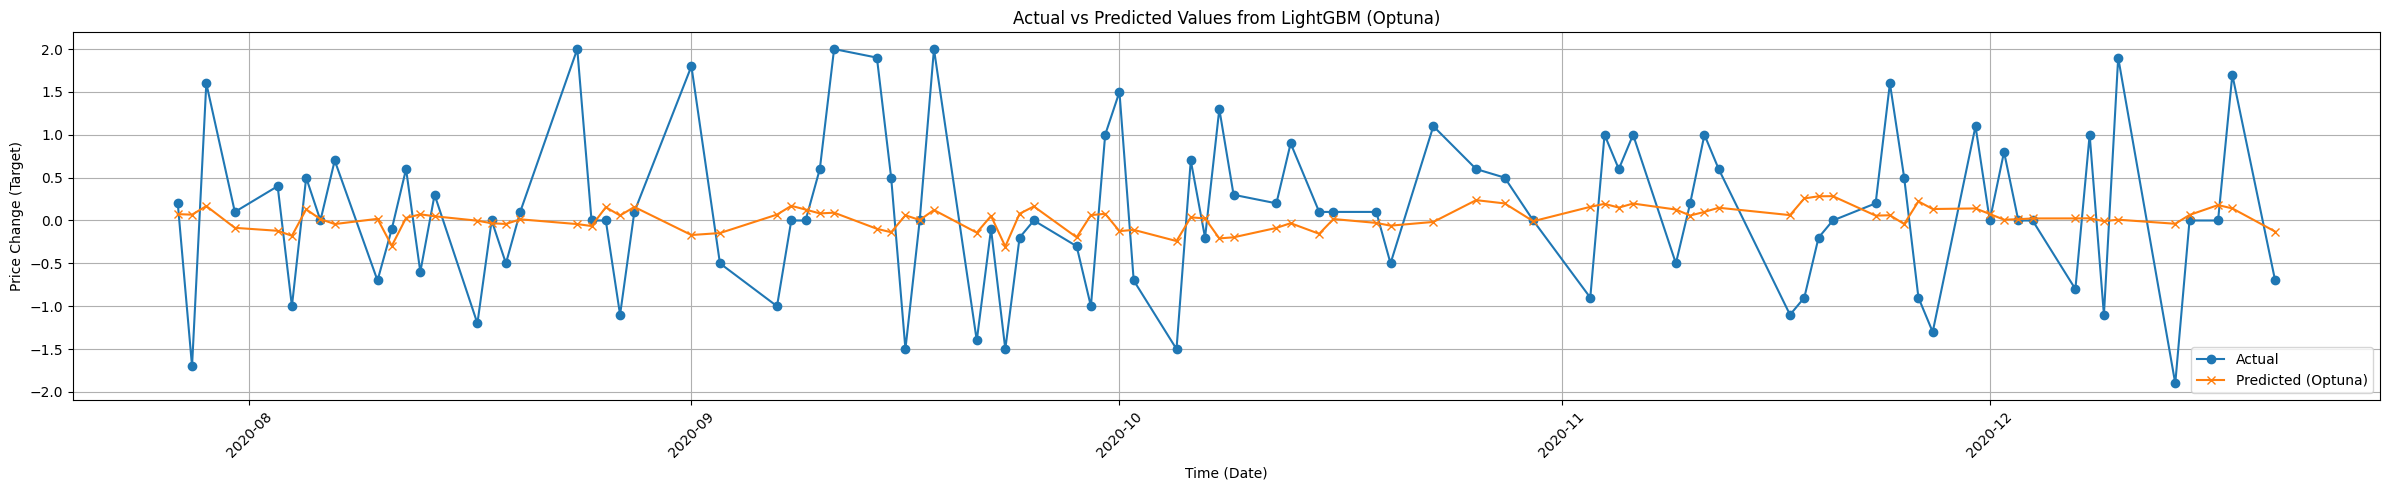

In [37]:
plot_test_predictions(VIC.loc[y_test.index, 'Date'].values, y_test.values, y_pred_test)

In [38]:
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mse)

print(f"[Final Result]")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

[Final Result]
MAE: 0.7170
RMSE: 0.9234


- Mặc dù kết quả MAE sau khi tối ưu có cải thiện nhưng khả năng bắt trend pattern của model giảm rõ rệt.
- Đường Predicted dao động quanh 0 và bị flattened quá mức.
- Có hiện tượng underfitting.